# Notebook 1: An introduction to `Solaris` and your working environment

This notebook is developed for the FOSS4G International 2019 `solaris` Workshop. If you're using it outside of that context, some of the working environment materials will be unavailable. Check the GitHub repo for instructions on how to alter the notebooks for usage outside of the workshop.

This notebook provides five parts:

1. [__Checking your `solaris` Installation__](#section1)
2. [__Listing the data provided__](#section2)
3. [__Input tile to building footprint vectors with 7 Python commands__](#section3)
3. [__Getting your pre-trained model ready__](#section4)
4. [__Running inference with `Solaris` on SpaceNet MVOI data__](#section5)
5. [__Visualizing outputs from the models__](#section6)

Let's get started!
f## Checking your solaris installation

The working environment provided for this workshop has `solaris` and all its dependencies pre-installed in a conda environment. If you're using the notebook outside of the workshop and need installation instructions, [click here](https://solaris.readthedocs.io/en/latest/installation.html).

Let's import `solaris` and check the package version to make sure it's available.

In [2]:
import solaris as sol
sol.__version__

'0.1.2'

<a id="section2"></a>
## Listing the data provided

We've provided a subset of the [SpaceNet](https://spacenet.ai) dataset for use in this workshop. If you're using the notebook outside of the FOSS4G International workshop, you'll need to collect the data yourself - see the GitHub repo containing this notebook for instructions on how to get the data you'll need.

First, let's look at the data provided.

In [3]:
import os

data_path = '/data'  # NON-WORKSHOP PARTICIPANTS: change this path to point to the directory where you've stored the data.
print('data contents:')
print(os.listdir(data_path))
print()
print('MVOI data:')
print(os.listdir(os.path.join(data_path, 'MVOI_data')))
print()
print('Other SpaceNet AOIs:')
print(os.listdir(os.path.join(data_path, 'spacenet_2_aois')))
print()
print('Configurations:')
print(os.listdir(os.path.join(data_path, 'workshop_configs')))


data contents:
['MVOI_data', 'workshop_configs', 'spacenet_2_aois']

MVOI data:
['MVOI_nadir10_test_sample.tif', '.DS_Store', 'MVOI_nadir10_test_sample.geojson', '.ipynb_checkpoints']

Other SpaceNet AOIs:
[]

Configurations:
['xdxd_workshop_infer.yml', 'xdxd_mvoi_inf.csv', '.ipynb_checkpoints']


The configurations path also contains .csv files that specify data for inference.

Here, you can see the different data that you have access to:

- Test images for the SpaceNet Off-Nadir Dataset (AKA [SpaceNet MVOI](https://arxiv.org/abs/1903.12239))
- Training images for SpaceNet Shanghai, Vegas, Khartoum, and Paris building footprint extraction
- Configuration files for a few different model training and inference processes

<a id="section3"></a>
## Running the full pipeline

First, we'll run the entire inference process, just to show you the end result of what you get from `solaris`. Below, we break down each step to describe what's going on.

Loading config...
config loaded. Initializing model...
model initialized. Loading dataset...
dataset loaded. Running inference on the image.
running inference on one image took 38.55253887176514 seconds
vectorizing output...
output vectorized.


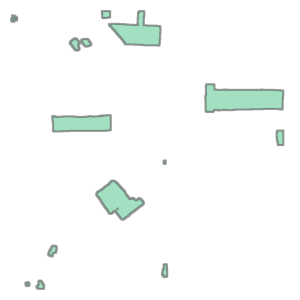

In [7]:
import time
import skimage
from shapely.ops import cascaded_union  # just for visualization purposes

print('Loading config...')
config = sol.utils.config.parse(os.path.join(data_path, 'workshop_configs/xdxd_workshop_infer.yml'))
print('config loaded. Initializing model...')
xdxd_inferer = sol.nets.infer.Inferer(config)
print('model initialized. Loading dataset...')
inf_df = sol.nets.infer.get_infer_df(config)
print('dataset loaded. Running inference on the image.')
start_time = time.time()
xdxd_inferer(inf_df)
end_time = time.time()
print('running inference on one image took {} seconds'.format(end_time-start_time))
print('vectorizing output...')
resulting_preds = skimage.io.imread(os.path.join('inference_out', 'MVOI_nadir10_test_sample.tif'))
predicted_footprints = sol.vector.mask.mask_to_poly_geojson(
    pred_arr=resulting_preds,
    reference_im=os.path.join(data_path, MVOI_data, inf_df.loc[0, 'image']))
print('output vectorized.')
cascaded_union(predicted_footprints['geometry'].values)

Excluding the printing and recording commands, __it only took 7 lines of code to run an entire inference pipeline, from input tile to output vectors!__

Let's visualize those labels alongside the source image and ground truth.

Text(0.5, 1.0, 'Ground Truth')

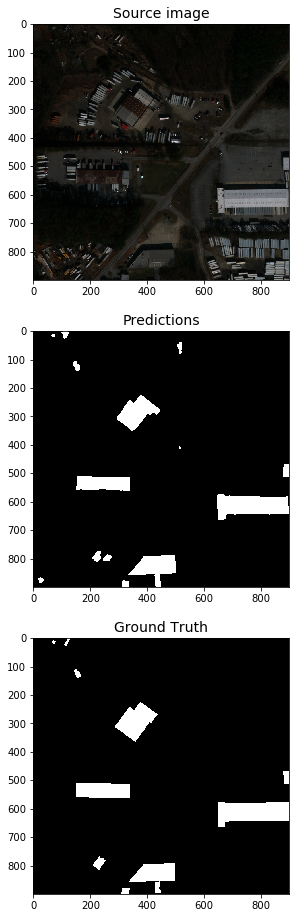

In [10]:
import numpy as np
import matplotlib.pyplot as plt

src_im_path = os.path.join(data_path, 'MVOI_data/MVOI_nadir10_test_sample.tif')
# read the image in
im_arr = skimage.io.imread(src_im_path)
# rescale to min/max in each channel
im_arr = im_arr.astype('float') - np.amin(im_arr, axis=(0,1))
im_arr = im_arr/np.amax(im_arr, axis=(0,1))
im_arr = (im_arr*255).astype('uint8')
# switch B and R for viz
tmp = im_arr[:, :, 0].copy()
im_arr[:, :, 0] = im_arr[:, :, 2]
im_arr[:, :, 2] = tmp
# generate mask from the predictions
pred_arr = sol.vector.mask.footprint_mask(predicted_footprints,
                                          reference_im=src_im_path)
ground_truth = sol.vector.mask.footprint_mask(
    os.path.join(data_path, 'MVOI_data/MVOI_nadir10_test_sample.geojson'),
    reference_im=src_im_path)

f, axarr = plt.subplots(3, 1, figsize=(8,16))
axarr[0].imshow(im_arr[:, :, 0:3])
axarr[0].set_title('Source image', size=14)
axarr[1].imshow(pred_arr, cmap='gray')
axarr[1].set_title('Predictions', size=14)
axarr[2].imshow(ground_truth, cmap='gray')
axarr[2].set_title('Ground Truth', size=14)

# A step-by-step walkthrough of the above steps

<a id="section4"></a>
## Getting your pre-trained model ready

For our first pass, we'll use a [standard configuration file for XD_XD's model](https://github.com/CosmiQ/solaris/blob/master/solaris/nets/configs/xdxd_spacenet4.yml). See [the YAML config tutorial](https://solaris.readthedocs.io/en/latest/tutorials/notebooks/creating_the_yaml_config_file.html) for a description of what each item means. Let's load in our model:

In [41]:
config = sol.utils.config.parse(os.path.join(data_path, 'workshop_configs/xdxd_workshop_infer.yml'))
config

{'model_name': 'xdxd_spacenet4',
 'model_path': None,
 'train': False,
 'infer': True,
 'pretrained': True,
 'nn_framework': 'torch',
 'batch_size': 12,
 'data_specs': {'width': 512,
  'height': 512,
  'image_type': 'zscore',
  'rescale': False,
  'rescale_minima': 'auto',
  'rescale_maxima': 'auto',
  'channels': 4,
  'label_type': 'mask',
  'is_categorical': False,
  'mask_channels': 1,
  'val_holdout_frac': 0.2,
  'data_workers': None},
 'training_data_csv': '/path/to/training_df.csv',
 'validation_data_csv': None,
 'inference_data_csv': 'data/workshop_configs/xdxd_mvoi_inf.csv',
 'training_augmentation': {'augmentations': {'DropChannel': {'idx': 3,
    'axis': 2},
   'HorizontalFlip': {'p': 0.5},
   'RandomRotate90': {'p': 0.5},
   'RandomCrop': {'height': 512, 'width': 512, 'p': 1.0},
   'Normalize': {'mean': [0.006479, 0.009328, 0.01123],
    'std': [0.004986, 0.004964, 0.00495],
    'max_pixel_value': 65535.0,
    'p': 1.0}},
  'p': 1.0,
  'shuffle': True},
 'validation_augmenta

As you can see, this converts the config file to a dictionary. `solaris` uses this `config` dictionary to specify all of the parameters for model training and inference (as well as some pre-processing steps). Then, you just pass the `config` object to the inference object:

In [42]:
xdxd_inferer = sol.nets.infer.Inferer(config)

The above should have downloaded the model weights for XD_XD's model to your instance's local storage. Note that this will happen automagically for any pre-trained SpaceNet model provided by `solaris` (if you haven't downloaded it already). If you wish to use your own model weights, simply point the `"model_path"` parameter of the config YAML file to your weights file.

Next, let's load in the .csv file that specifies the image we're going to run inference on:

In [43]:
inf_df = sol.nets.infer.get_infer_df(config)
inf_df

,image
0,data/MVOI_data/MVOI_nadir10_test_sample.tif


Once again, we're reading the path to the data to analyze from the `config`. This generates a pandas DataFrame with a column, `"image"`, that points to the images to run inference on. Obviously, we only have one image for the example here.

We're ready to run inference! 

<a id="section5"></a>
## Running inference

Running inference is as easy as calling your inferer (`xdxd_inferer`) with the inference target dataframe (here, `inf_df`) as an argument. This will run the entire inference process on that image and save the resulting mask as a TIFF file. _This may take some time, particularly if you're not using a GPU - be patient!)_

In [44]:
model_result_mask = xdxd_inferer(inf_df)

And you're done! Simple as that. Let's check out what that mask looks like:

<a id="section6"></a>
## Visualizing inference outputs

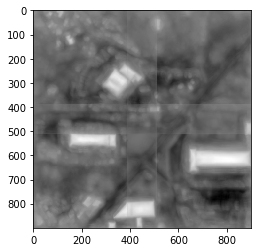

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

resulting_preds = skimage.io.imread(os.path.join('inference_out', 'MVOI_nadir10_test_sample.tif'))
plt.imshow(resulting_preds[:, :, 0], cmap='gray')

The above is a pixel mask where higher values indicate higher probability of a pixel corresponding to buildings. We can binarize this to convert to a building/no building image:

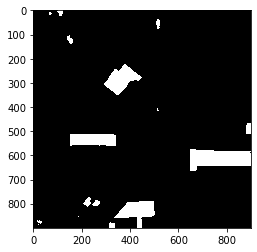

In [46]:
binary_preds = resulting_preds > 0
plt.imshow(binary_preds.astype('uint8')[:, :, 0], cmap='gray')

All that you can get directly from this, though, is "which pixels are part of buildings?" This isn't that useful, though, for identifying individual buildings; let's generate a more useful output, i.e. georegistered building footprints:

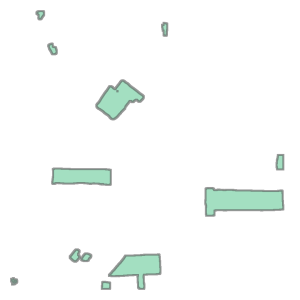

In [18]:
from shapely.ops import cascaded_union  # just for visualization
predicted_footprints = sol.vector.mask.mask_to_poly_geojson(
    pred_arr=resulting_preds,
    reference_im=inf_df.loc[0, 'image'],
    do_transform=True)

cascaded_union(predicted_footprints['geometry'].values)

That's better. Note the geometries are flipped vertically because in this coordinate reference system higher values indicate further north (up), whereas in `numpy` arrays higher indices correspond to further _down_.

In [19]:
print(predicted_footprints['geometry'])

0     POLYGON ((745804.5 3726489, 745812.5 3726489, ...
1     POLYGON ((746007 3726470, 746008.5 3726470, 74...
2     POLYGON ((745825.5 3726436.5, 745826.5 3726436...
3     POLYGON ((745940.5 3726377, 745941 3726377, 74...
4     POLYGON ((746192.5 3726256, 746201 3726256, 74...
5     POLYGON ((745829.5 3726234, 745842 3726234, 74...
6     POLYGON ((746078 3726202.5, 746080.5 3726202.5...
7     POLYGON ((745865 3726103, 745868 3726103, 7458...
8     POLYGON ((745880.5 3726096.5, 745883.5 3726096...
9     POLYGON ((745763 3726056.5, 745764.5 3726056.5...
10    POLYGON ((745998 3726095, 745999.5 3726095, 74...
11    POLYGON ((745909 3726050.5, 745912.5 3726050.5...
Name: geometry, dtype: object


In [20]:
predicted_footprints.crs

CRS.from_dict(init='epsg:32616')